# BERT & TF

In [1]:
!pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8MB 38kB/s 
     |████████████████████████████████| 3.9MB 35.0MB/s 
     |████████████████████████████████| 450kB 67.6MB/s 
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [3]:
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import os
import re
import numpy as np
import pickle as pk
import string
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm_notebook
from collections import defaultdict
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy import stats

# Params for bert model and tokenization
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

tf.__version__

'2.1.0'

In [4]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Load Data - Latest Data Split - Blind

In [5]:
!wget https://raw.githubusercontent.com/harish-cu/tweet-url-relationships/master/data/temp/sampling_blind/latest/articles_train.csv
!wget https://raw.githubusercontent.com/harish-cu/tweet-url-relationships/master/data/temp/sampling_blind/latest/articles_test.csv
!wget https://raw.githubusercontent.com/harish-cu/tweet-url-relationships/master/data/processed/article_topics_6.csv

--2020-03-05 19:13:53--  https://raw.githubusercontent.com/harish-cu/tweet-url-relationships/master/data/temp/sampling_blind/latest/articles_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6523814 (6.2M) [text/plain]
Saving to: ‘articles_train.csv’

articles_train.csv  100%[===================>]   6.22M  --.-KB/s    in 0.04s   

2020-03-05 19:13:54 (165 MB/s) - ‘articles_train.csv’ saved [6523814/6523814]

--2020-03-05 19:13:58--  https://raw.githubusercontent.com/harish-cu/tweet-url-relationships/master/data/temp/sampling_blind/latest/articles_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:4

In [0]:
data_train = pd.read_csv("articles_train.csv")
data_test = pd.read_csv("articles_test.csv")
data_topics = pd.read_csv("article_topics_6.csv")

In [7]:
data_topics['topic'].value_counts()

Politics         586
Public Health    402
Scandal          374
Policy           253
Technology       181
Economy          118
Name: topic, dtype: int64

In [6]:
data_train.head()

,content_id,month,day,year,date,content_source_desc,content_title_clean,content_body_clean,blind_mean_rating,blind_rating_count,blind_ratings
0,2932,11,2,2017,2017-11-02,The New York Times,A Tax Cut That Lifts the Economy? Opinions Are...,Yet if the House plan resolves some longstandi...,3.177778,45,"[4.5, 1.5, 0.5, 4.5, 1.0, 4.0, 3.5, 3.5, 1.5, ..."
1,2870,11,1,2017,2017-11-01,Fox News,"Tom Tancredo enters Colorado governor's race, ...",Former U.S. Rep. Tom Tancredo announced Tuesda...,2.375000,16,"[3.5, 4.0, 3.0, 2.5, 0.5, 3.0, 0.5, 0.5, 4.5, ..."
2,2869,11,1,2017,2017-11-01,The New York Times,Panel Recommends Opioid Solutions but Puts No ...,President Trump’s bipartisan commission on th...,3.916667,6,"[5.0, 4.0, 4.5, 3.5, 2.0, 4.5]"
3,2864,11,1,2017,2017-11-01,Fox News,"Trump vows to end non merit-base immigration, ...",President Trump vowed Wednesday to scrap the f...,2.100000,5,"[2.0, 2.5, 4.0, 0.5, 1.5]"
4,2868,11,1,2017,2017-11-01,Breitbart,WATCH: Congress Holds Hearing on Banning Abort...,Congress will hold a hearing Wednesday on a bi...,2.428571,21,"[2.0, 1.0, 0.5, 1.0, 3.5, 5.0, 2.0, 0.5, 2.5, ..."


In [0]:
#clean data
def clean_data(text):
    #remove punctuation, digits, extra stuff. make lowercase
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    #lemma it - include POS tag in order to lemma it better
    tag_map = defaultdict(lambda : wordnet.NOUN)
    tag_map['J'] = wordnet.ADJ
    tag_map['V'] = wordnet.VERB
    tag_map['R'] = wordnet.ADV
    lemmatizer = WordNetLemmatizer()
    textTokens = word_tokenize(text)
    #remove stopwords
    word_tokens_nostop = [w for w in textTokens if not w in stopwords.words('english')] 
    #now lemma
    text = [lemmatizer.lemmatize(tok, tag_map[tag[0]]) for tok, tag in pos_tag(word_tokens_nostop)]
    return " ".join(text)

### Get clean body

In [0]:
clean_body_train = data_train["content_body_clean"].apply(clean_data)
y_train = data_train['blind_mean_rating']

clean_body_test = data_test["content_body_clean"].apply(clean_data)
y_test = data_test['blind_mean_rating']

In [0]:
source_train = pd.get_dummies(data_train['content_source_desc'])
source_test = pd.get_dummies(data_test['content_source_desc'])

In [10]:
source_train.shape

(1301, 7)

In [0]:
topics_train = pd.DataFrame(columns=['topic'])
for index, row in data_train.iterrows():
  topics_train = topics_train.append({'topic':data_topics[data_topics['content_id']==row['content_id']]['topic'].values[0]}, ignore_index=True)
topics_test = pd.DataFrame(columns=['topic'])
for index, row in data_test.iterrows():
  topics_test = topics_test.append({'topic':data_topics[data_topics['content_id']==row['content_id']]['topic'].values[0]}, ignore_index=True)

In [0]:
topic_train = pd.get_dummies(topics_train['topic'])
topic_test = pd.get_dummies(topics_test['topic'])

In [71]:
topic_train.head()

,Economy,Policy,Politics,Public Health,Scandal,Technology
0,0,1,0,0,0,0
1,0,0,1,0,0,0
2,0,0,0,1,0,0
3,0,0,1,0,0,0
4,0,0,0,0,1,0


### Split train and val

In [0]:
X_train, X_val, y_train_t, y_val, source_train_t, source_val, topic_train_t, topic_val = train_test_split(clean_body_train, y_train, source_train, topic_train, 
                                                                                                          test_size=0.15, shuffle=True, random_state=3)

In [0]:
y_train_std = np.array(list(y_train_t))
y_val_std = np.array(list(y_val))
y_test_std = np.array(list(y_test))

### Tokenize, Sequence, Pad

In [23]:
VOCAB_SIZE = 29377

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(clean_body_train)

# Note, the tokenizer's word_index will not respect VOCAB_SIZE.
# but, that parameter will be respected in later methods,
# (for example, when you call text_to_sequences).
# Also note that '0' is a reserved index for padding.
word_index = tokenizer.word_index
print("Word index", len(word_index))

Word index 29377


In [0]:
# Use the texts_to_sequences utility to vectorize your training, 
# validation, and test questions. 
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_val = tokenizer.texts_to_sequences(X_val)
sequences_test = tokenizer.texts_to_sequences(clean_body_test)

### Choose max sequence length

In [25]:
train_word_lengths = []
for w in sequences_train:
    train_word_lengths.append(len(w))
words_length = np.array(train_word_lengths)

print("# of Words in the 90 percentile:",np.percentile(words_length, 90))
print("# of Words in the 95 percentile:",np.percentile(words_length, 95))
print("# of Words in the 99 percentile:",np.percentile(words_length, 99))
print("# of Words in the 100 percentile:",np.percentile(words_length, 100))

# of Words in the 90 percentile: 764.6
# of Words in the 95 percentile: 1103.6
# of Words in the 99 percentile: 1894.2000000000035
# of Words in the 100 percentile: 9317.0


In [0]:
MAX_SEQ_LEN = 2000

### Pad

In [0]:
padded_train = tf.keras.preprocessing.sequence.pad_sequences(sequences_train, maxlen=MAX_SEQ_LEN)
padded_val = tf.keras.preprocessing.sequence.pad_sequences(sequences_val, maxlen=MAX_SEQ_LEN)
padded_test = tf.keras.preprocessing.sequence.pad_sequences(sequences_test, maxlen=MAX_SEQ_LEN)

In [28]:
len(padded_train[0])

2000

### Initial LSTM model

In [0]:
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, LSTM, GRU, Bidirectional, Dropout
#from tensorflow.keras.layers.embeddings import Embedding
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant

In [0]:
model = Sequential()
embedding_layer = Embedding(input_dim=num_words,
                            output_dim=EMBED_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQ_LEN,
                            trainable=False
                           )
model.add(embedding_layer)
#model.add(Flatten())
model.add(Bidirectional(LSTM(64)))
#model.add(GRU(units=32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation=None))

model.summary()

"""[
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=64, input_length=MAX_SEQ_LEN),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
]"""

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 64)          1880192   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,954,561
Trainable params: 74,369
Non-trainable params: 1,880,192
_________________________________________________________________


'[\n    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=64, input_length=MAX_SEQ_LEN),\n    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),\n    tf.keras.layers.Dense(64, activation="relu"),\n    tf.keras.layers.Dense(1, activation="sigmoid")\n]'

In [0]:
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=11, verbose=0, mode='min')
cp_save = tf.keras.callbacks.ModelCheckpoint('model-e{epoch:03d}.ckpt', 
                                             save_best_only=True, monitor='val_mse', mode='min')

In [0]:
!rm -rf 'model-e001.ckpt'
!rm -rf 'model-e002.ckpt'
!rm -rf 'model-e006.ckpt'
!rm -rf 'model-e013.ckpt'
!rm -rf 'model-e016.ckpt'

In [0]:
history = model.fit(padded_train, y_train_std, 
                     epochs=100, 
                     verbose=2, 
                     callbacks=[earlyStopping, cp_save],
                     validation_data=(padded_val,y_val_std))

Train on 1105 samples, validate on 196 samples
Epoch 1/100
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model-e001.ckpt/assets
1105/1105 - 33s - loss: 2.8116 - mse: 2.8116 - val_loss: 0.6757 - val_mse: 0.6757
Epoch 2/100
INFO:tensorflow:Assets written to: model-e002.ckpt/assets
1105/1105 - 25s - loss: 0.9587 - mse: 0.9587 - val_loss: 0.6242 - val_mse: 0.6242
Epoch 3/100
1105/1105 - 5s - loss: 0.9693 - mse: 0.9693 - val_loss: 0.6278 - val_mse: 0.6278
Epoch 4/100
1105/1105 - 6s - loss: 0.9329 - mse: 0.9329 - val_loss: 0.6670 - val_mse: 0.6670
Epoch 5/100
1105/1105 - 6s - loss: 0.9025 - mse: 0.9025 - val_loss: 0.6352 - val_mse: 0.6352
Epoch 6/100
INFO:tensorflow:Assets written to: model-e006.ckpt/assets
1105/1105 - 25s - loss: 0.8971 - mse: 0.8971 - val_loss: 0.6186 - val_mse: 0.6186
Epoch 7/100
1105/1105 - 6s - loss: 0.9035 - mse: 0.9035 - val_loss: 0.7048 - val_mse: 0.7048
Epoch 8/100
1105/1105 - 6s - loss: 0.9105 - 

In [0]:
#plotting accuracy and loss as a function of epochs to ensure no overfitting
def plot(history):
    # The history object contains results on the training and test
    # sets for each epoch
    acc = history.history['mse']
    val_acc = history.history['val_mse']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get the number of epochs
    epochs = range(len(acc))

    plt.title('Training and validation accuracy')
    plt.plot(epochs, acc, color='blue', label='Train')
    plt.plot(epochs, val_acc, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()

    #_ = plt.figure()
    #plt.title('Training and validation loss')
    #plt.plot(epochs, loss, color='blue', label='Train')
    #plt.plot(epochs, val_loss, color='orange', label='Val')
    #plt.xlabel('Epoch')
    #plt.ylabel('Loss')
    #plt.legend()

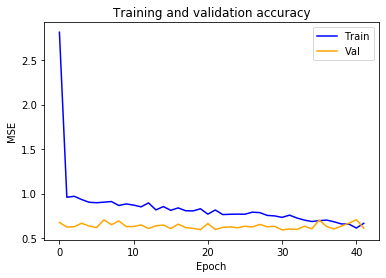

In [0]:
plot(history)

### Testing

In [0]:
model1_best = tf.keras.models.load_model('model-e031.ckpt')

In [0]:
pred1 = model1_best.predict(x=padded_test)
pred_arr = [p[0] for p in pred1]

d = np.subtract(np.array(pred_arr),y_test_std)
test_mse = np.mean(np.square(d))
test_rmse = np.sqrt(test_mse)
test_mae = np.mean(abs(d))
test_pearsonr = stats.pearsonr(y_test_std, pred_arr)

print("Test Results on best model epoch")
print("RMSE:",test_rmse)
print("MAE:",test_mae)
print("Pearson R & P-value:",test_pearsonr)

Test Results on best model epoch
RMSE: 0.9685732333588796
MAE: 0.7746089153937775
Pearson R & P-value: (0.3400114970748387, 2.8950468124683984e-10)


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import shutil
#zip
if not os.path.exists('/content/drive/My Drive/DNNmodel1.zip'):
  model1_archive = shutil.make_archive('/content/drive/My Drive/DNNmodel1', 'zip', '/content/model-e031.ckpt')
  print(model1_archive)
  print(os.path.getsize(model1_archive)/1048576,"mb")
else:
  print('Zip archive exists')

/content/drive/My Drive/DNNmodel1.zip
34.164793968200684 mb


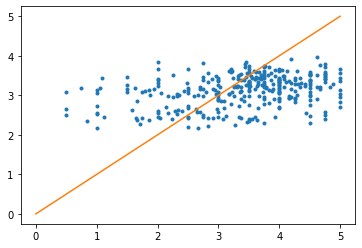

In [0]:
# Test Data Prediction
plt.plot(y_test_std, pred_arr, '.')
# plot a line, a perfit predict would all fall on this line
x = np.linspace(0, 5)
plt.plot(x, x)
plt.show()

# Model 3 - Adding Source to Simple Model

In [34]:
source_train_t.head()

,100 Percent Fed Up,Associated Press News,Breitbart,Fox News,Media Matters,The New York Times,Vox
374,0,1,0,0,0,0,0
637,0,0,0,1,0,0,0
85,0,0,0,0,0,1,0
1299,0,0,0,0,0,0,1
152,0,0,0,0,0,1,0


In [0]:
source_train_arr = np.array(source_train_t)
source_val_arr = np.array(source_val)

In [41]:
# two inputs
body_input = Input(shape=(MAX_SEQ_LEN,))

embedding_l = Embedding(input_dim=num_words,
                            output_dim=EMBED_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQ_LEN,
                            trainable=False
                           )(body_input)

LSTM_out = Bidirectional(LSTM(64))(embedding_l)

source_input = Input(shape=(7,), name='source_input')

x = tf.keras.layers.concatenate([LSTM_out, source_input])
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
out = Dense(1, activation=None)(x)

model3 = Model(inputs=[body_input, source_input], outputs=out)

model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 2000)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 2000, 64)     1880192     input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 128)          66048       embedding_3[0][0]                
__________________________________________________________________________________________________
source_input (InputLayer)       [(None, 7)]          0                                            
____________________________________________________________________________________________